<span style="font-size:2em;">**International football results from 1872 to 2021**</span>

This dataset has over 42000 results from international men's football matches from 1972 to 2021. It includes different competitions like FIFA World Cup and friendly matches and is divided into two files: **results** and **shootouts**. 

The **results** file is composed of the following variables:
- **date** - date of the match.
- **home_team** - the name of the home team.
- **away_team** - the name of the away team.
- **home_score** - full-time home team score including extra time, not including penalty-shootouts.
- **away_score** - full-time away team score including extra time, not including penalty-shootouts.
- **tournament** - the name of the tournament.
- **city** - the name of the city/town/administrative unit where the match was played.
- **country** - the name of the country where the match was played.
- **neutral** - TRUE/FALSE column indicating whether the match was played at a neutral venue.

The **shootouts** csv has 4 columns:
- **date** - date of the match.
- **home_team** - the name of the home team.
- **away_team** - the name of the away team.
- **winner** - winner of the penalty-shootout.

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

# Descriptive Statistics

Let's load the dataset and look at the descriptive statistics.

In [2]:
results_df = pd.read_csv('../data/raw/results.csv')
shootouts_df = pd.read_csv('../data/raw/shootouts.csv')

In [3]:
results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


The first 5 international football matches were played between Scotland and England.

In [4]:
shootouts_df.head()

,date,home_team,away_team,winner
0,1967-08-22,India,Taiwan,Taiwan
1,1971-11-14,South Korea,Vietnam Republic,South Korea
2,1972-05-17,Thailand,South Korea,South Korea
3,1972-05-19,Thailand,Cambodia,Thailand
4,1973-07-26,Malaysia,Kuwait,Malaysia


The first penalty shoot-out took place in a friendly match between India and Taiwan. More info about the history of penalty shoot-outs can be seen [here](https://www.fifamuseum.com/en/blog-stories/blog/why-the-lottery-that-is-penalty-shoot-outs-were-introduced-2610606/).

In [5]:
results_df.describe().T

,count,mean,std,min,25%,50%,75%,max
home_score,43081.0,1.743228,1.753982,0.0,1.0,1.0,2.0,31.0
away_score,43081.0,1.183608,1.400620,0.0,0.0,1.0,2.0,21.0


The team that plays at home scores more goals on average.

There was a game where the home team scored 31 goals and another where the away team scored 21. Before we go any further, let's check which games we are talking about.

In [6]:
results_df[(results_df['home_score'] == 31) | (results_df['away_score'] == 21)]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
23917,2001-04-11,Australia,American Samoa,31.0,0.0,FIFA World Cup qualification,Coffs Harbour,Australia,False
27494,2005-03-11,Guam,North Korea,0.0,21.0,EAFF Championship,Taipei,Taiwan,True


**Australia vs American Samoa** can be considered a David vs Goliath fight. Australia has won 4 OFC Nations Cup and 1 AFC Asian Cup, while American Samoa has lost 45 out of 51 matches in its entire history.

The **EAFF Championship** is a competition in East Asia for national teams like China, South Korea and Japan. The current champion is South Korea.

Missing values might affect the analysis, so we are going to see if there are any.

In [7]:
results_df.isnull().sum()

date          0
home_team     2
away_team     2
home_score    5
away_score    5
tournament    0
city          0
country       0
neutral       2
dtype: int64

In [8]:
shootouts_df.isnull().sum()

date         0
home_team    0
away_team    0
winner       0
dtype: int64

There are missing values. Since they are few, let's just ignore them by deleting these rows.

In [9]:
results_df.drop(results_df[results_df.isna().any(axis=1)].index, inplace=True)

To complement the data we already have, we will load the lists of teams belonging to each [FIFA confederation](https://en.wikipedia.org/wiki/List_of_football_federations#FIFA_Confederations).

In [10]:
afc = [team.strip() for team in open('../data/raw/AFC', 'r').read().split('\n')]
caf = [team.strip() for team in open('../data/raw/CAF', 'r').read().strip().split('\n')]
concacaf = [team.strip() for team in open('../data/raw/Concacaf', 'r').read().strip().split('\n')]
conmebol = [team.strip() for team in open('../data/raw/Conmebol', 'r').read().strip().split('\n')]
ofc = [team.strip() for team in open('../data/raw/OFC', 'r').read().strip().split('\n')]
uefa = [team.strip() for team in open('../data/raw/UEFA', 'r').read().strip().split('\n')]

# Data Processing

For starters, we are renaming the columns for plotting purposes.

In [11]:
results_df.rename(columns={'date': 'Date', 
                           'home_team': 'Home Team', 
                           'away_team': 'Away Team',
                           'home_score': 'Home Score',
                           'away_score': 'Away Score',
                           'tournament': 'Tournament',
                           'city': 'City',
                           'country': 'Country',
                           'neutral': 'Neutral'}, inplace=True)

shootouts_df.rename(columns={'date': 'Date',
                             'home_team': 'Home Team', 
                             'away_team': 'Away Team',
                             'winner': 'Winner'}, inplace=True)

By creating columns with the result of the match and the total number of goals scored along with the winning and losing teams, we have faster access to the result of the match. In addition, we will add some date-related features: decade, year, month and day of the week.

In [69]:
results_df['Outcome'] = results_df.apply(lambda x : 'H' if x['Home Score'] > x['Away Score'] 
                                         else ('A' if x['Home Score'] < x['Away Score'] else 'D'),
                                         axis=1)

results_df['Winning Team'] = results_df.apply(lambda x : x['Home Team'] if x['Home Score'] > x['Away Score'] 
                                              else (x['Away Team'] if x['Home Score'] < x['Away Score'] else np.nan),
                                              axis=1)

results_df['Losing Team'] = results_df.apply(lambda x : x['Away Team'] if x['Home Score'] > x['Away Score'] 
                                             else (x['Home Team'] if x['Home Score'] < x['Away Score'] else np.nan),
                                             axis=1)

results_df['Total Goals'] = results_df.apply(lambda x: x['Home Score'] + x['Away Score'], axis=1)
results_df['Year'] = pd.DatetimeIndex(results_df['Date']).year
results_df['Decade'] = results_df['Year'] - results_df['Year'] % 10
results_df['Month'] = pd.DatetimeIndex(results_df['Date']).month
results_df['Month Name'] = pd.DatetimeIndex(results_df['Date']).month_name()
results_df['Day of Week'] = pd.DatetimeIndex(results_df['Date']).day_name()

There are two matches with the wrong team order in the **results.csv** file, it is necessary to correct them to merge results and shootouts.

In [70]:
results_df['Home Team'].iloc[31849] = 'South Africa'
results_df['Away Team'].iloc[31849] = 'Zimbabwe'
results_df['Home Team'].iloc[40795] = 'Uganda'
results_df['Away Team'].iloc[40795] = 'South Africa'

The results_df dataframe does not include results after penalties, so we are filling in the **Winning Team** and **Losing Team** columns in games that required penalties to determine the winners.

In [71]:
football_df = results_df.merge(shootouts_df, how='left', on=['Home Team', 'Away Team', 'Date'])

football_df['Winning Team'] = football_df.apply(
    lambda x: x['Winner'] if not pd.isnull(x['Winner']) and pd.isnull(x['Winning Team']) 
    else x['Winning Team'], 
    axis=1)

football_df['Losing Team'] = football_df.apply(
    lambda x: x['Home Team'] if x['Winning Team'] == x['Away Team'] and x['Outcome'] == 'D' 
    else x['Away Team'] if x['Winning Team'] == x['Home Team'] and x['Outcome'] == 'D' 
    else x['Losing Team'], axis=1)

football_df.drop(columns = ['Winner'], inplace=True)

We should check if the above features were created correctly.

In [72]:
football_df.head()

,Date,Home Team,Away Team,Home Score,Away Score,Tournament,City,Country,Neutral,Outcome,Winning Team,Losing Team,Total Goals,Year,Decade,Month,Day of Week,Month Name
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,D,NaN,NaN,0.0,1872,1870,11,Saturday,November
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,H,England,Scotland,6.0,1873,1870,3,Saturday,March
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,H,Scotland,England,3.0,1874,1870,3,Saturday,March
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,D,NaN,NaN,4.0,1875,1870,3,Saturday,March
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,H,Scotland,England,3.0,1876,1870,3,Saturday,March


Everything checks out!

Also, we are creating a dataframe with all the teams, the year of their first international match and their affiliations.

In [73]:
affiliations_df = pd.DataFrame({
    'Affiliation' : ['AFC'] * len(afc) + ['CAF'] * len(caf) + ['CONCACAF'] * len(concacaf) + \
    ['CONMEBOL'] * len(conmebol) + ['OFC'] * len(ofc) + ['UEFA'] * len(uefa),
    'Region' : ['Asia'] * len(afc) + ['Africa'] * len(caf) + ['North and Central America'] * len(concacaf) + \
    ['South America'] * len(conmebol) + ['Oceania'] * len(ofc) + ['Europe'] * len(uefa),
    'Team': afc + caf + concacaf + conmebol + ofc + uefa
})

In [74]:
all_teams = list(football_df['Home Team'].unique())
all_teams.extend(list(football_df['Away Team'].unique()))
all_teams_df = pd.DataFrame({'Team': list(set(all_teams))})
all_teams_df['First Game Year'] = all_teams_df['Team'].apply(lambda x: football_df[(football_df['Home Team'] == x) | (football_df['Away Team'] == x)].head(1)['Year'].values[0])
all_teams_df['First Game Decade'] = all_teams_df['First Game Year'] - all_teams_df['First Game Year'] % 10
all_teams_df = all_teams_df.merge(affiliations_df, how='left', on=['Team'])
all_teams_df.sort_values(by='First Game Year', inplace=True)
all_teams_df.head()

,Team,First Game Year,First Game Decade,Affiliation,Region
47,Scotland,1872,1870,UEFA,Europe
219,England,1872,1870,UEFA,Europe
53,Wales,1876,1870,UEFA,Europe
136,Northern Ireland,1882,1880,UEFA,Europe
160,Canada,1885,1880,CONCACAF,North and Central America


Finally, let's create a list with the days of the week in order, which will be useful during the analysis.

In [75]:
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

We are ready to plot!

# Data Visualization

Let's go through the rest of this notebook creating different charts to answer a few questions.

**How has football been adopted over time?**

To understand how football has been adopted over time, we are looking at the number of new national teams per decade.

In [76]:
new_teams_decade = all_teams_df['First Game Decade'].value_counts().sort_index()

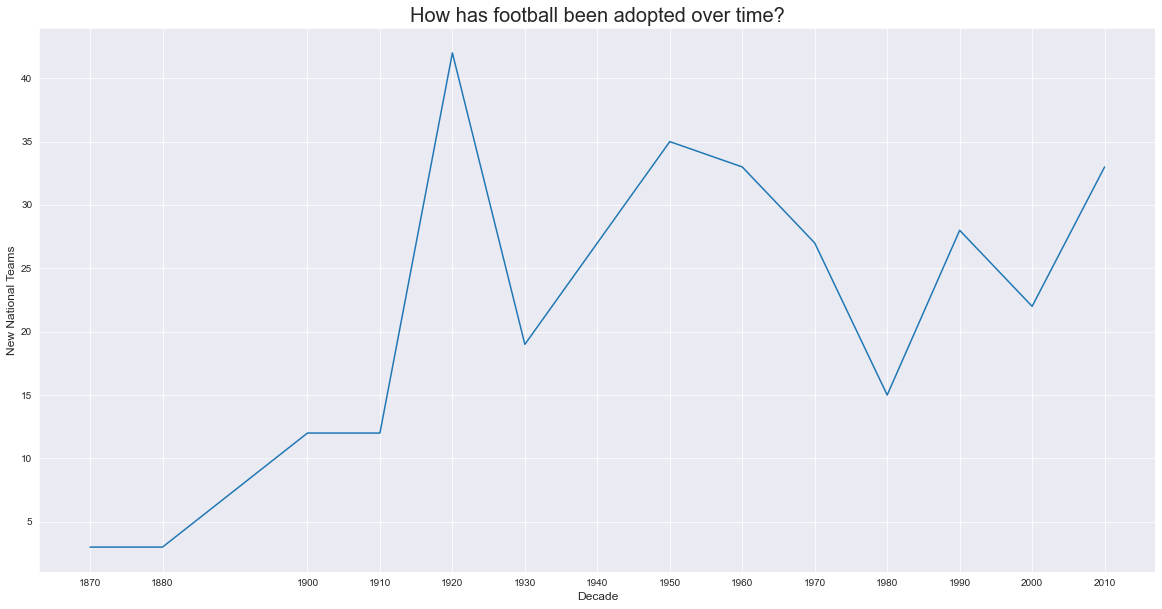

In [77]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(data=new_teams_decade, x=new_teams_decade.index, y=new_teams_decade.values)
ax.set_title('How has football been adopted over time?', size=20)
ax.set_xlabel(xlabel='Decade', size=12)
ax.set_ylabel(ylabel='New National Teams', size=12)
ax.set(xticks=new_teams_decade.index);

The number of new national teams spiked up between the very beginning and 1920. Then the trend reversed for a long time, until the 80s.

Before drawing any further conclusions, let's analyze these numbers grouped by region.

In [78]:
new_teams_decade_region_df = all_teams_df[['First Game Decade', 'Region']].value_counts().sort_index().reset_index(level=1)
new_teams_decade_region_df.rename(columns={0: 'Count'}, inplace=True)
new_teams_decade_region_df = pd.pivot(new_teams_decade_region_df,columns='Region', values='Count')

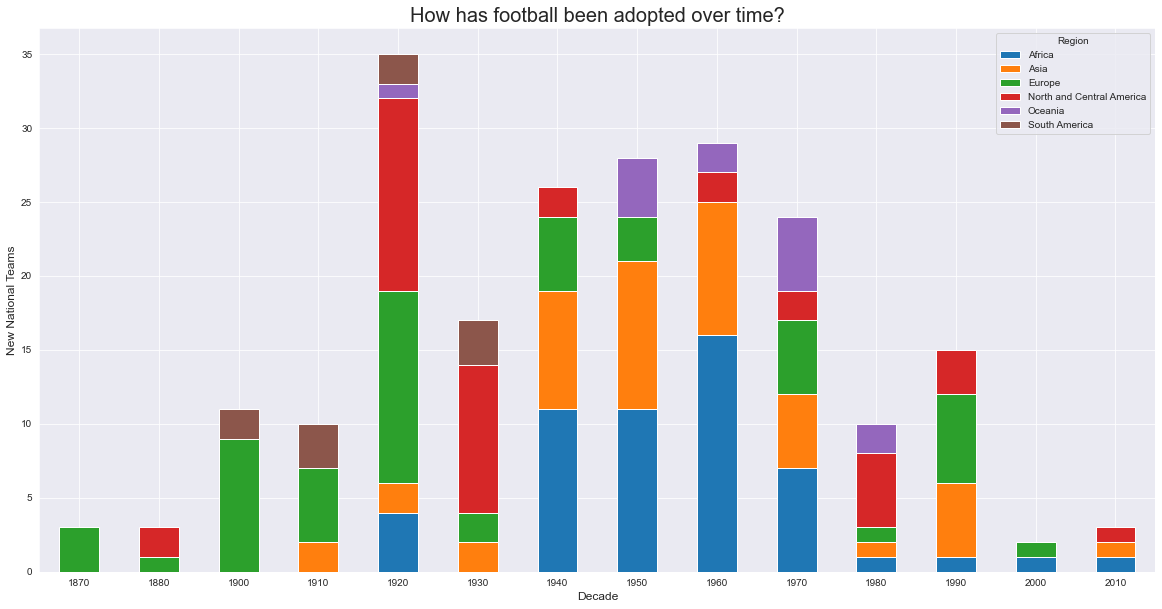

In [79]:
ax = new_teams_decade_region_df.plot(kind='bar', stacked=True, figsize=(20,10))
ax.set_title('How has football been adopted over time?', size=20)
ax.set_xlabel(xlabel='Decade', size=12)
ax.set_ylabel(ylabel='New National Teams', size=12)
plt.xticks(rotation=0);

Europe was the first major contributor to new national teams. Then the Americas took the lead in the 20s and 30s. 

Africa and Asia dominated between 1940 and 1980. The growth in Europe in the 90s must be explained by the emergence of new countries, such as those derived from the former Yugoslavia.

**How many matches per year?**

We are going to plot the number of matches per year to have another metric that shows how football has been adopted over time. For a better understanding, let's highlight the World Cup years and some big events (World War I, World War II and COVID-19).

In [80]:
games_per_year = football_df['Year'].value_counts().sort_index()

# Get list of decades to define the labels of the x-axis
decades = football_df['Decade'].unique()

# Get World Cup years to point out the number of matches in those years
world_cup_years = football_df[football_df['Tournament'] == 'FIFA World Cup']['Year'].unique()
world_cup_years_games = games_per_year[games_per_year.index.isin(world_cup_years)]

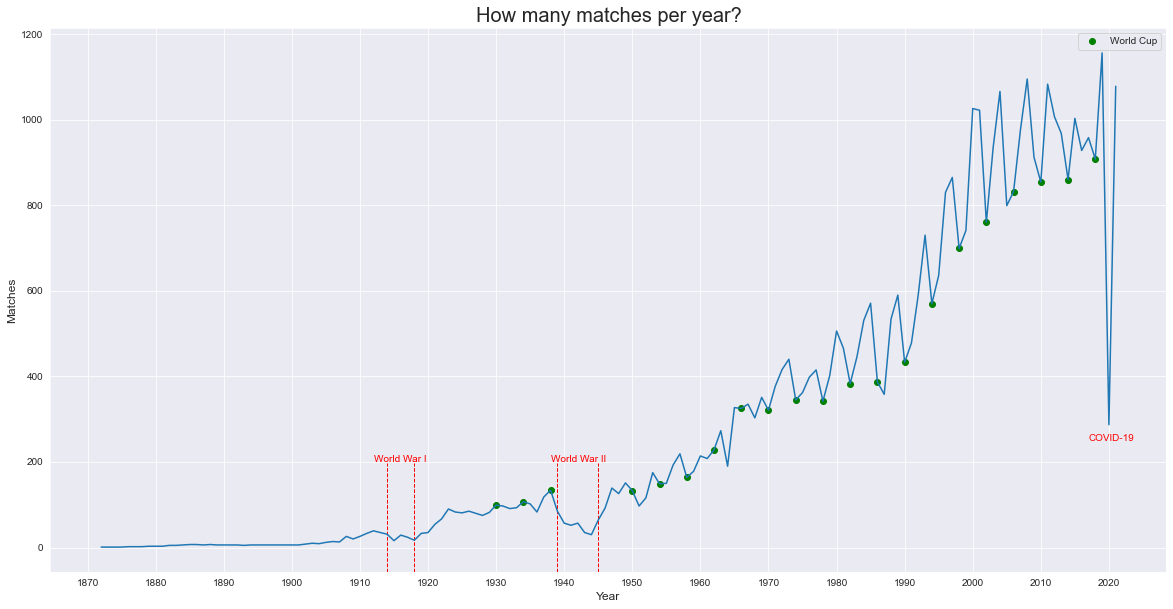

In [81]:
plt.figure(figsize=(20,10))

# Mark the time intervals of the World Wars on the chart
plt.axvline(x = 1914, color = 'r', linestyle = 'dashed', linewidth=1, ymax=0.2)
plt.axvline(x = 1918, color = 'r', linestyle = 'dashed', linewidth=1, ymax=0.2)
plt.text(1912, 200, 'World War I', color='red')

plt.axvline(x = 1939, color = 'r', linestyle = 'dashed', linewidth=1, ymax=0.2)
plt.axvline(x = 1945, color = 'r', linestyle = 'dashed', linewidth=1, ymax=0.2)
plt.text(1938, 200, 'World War II', color='red')

# Highlight years of the World Cup
plt.plot(world_cup_year_games, 'go', label='World Cup')

# Emergence of COVID-19
plt.text(2017, 250, 'COVID-19', color='red'); 

ax = sns.lineplot(data=games_per_year, x=games_per_year.index, y=games_per_year.values)
ax.set_title('How many matches per year?', size=20)
ax.set_xlabel(xlabel='Year', size=12)
ax.set_ylabel(ylabel='Matches', size=12)
ax.set(xticks=decades);

The first trend was that in World Cup years there were more international matches. However, that trend has long since reversed, which makes sense because there are now many qualifying matches in previous years and continental competitions like the Euro and Copa America.

To note that as expected there were fewer matches during the World Wars. Yet, the biggest drop was caused by COVID-19. 

**How many matches per month?**

Let's see how the matches have been distributed by the months of the year.

In [83]:
games_per_month = football_df[['Month', 'Month Name', 'Year']].value_counts().reset_index().sort_values(by=['Month', 'Year'])
games_per_month.rename(columns={0: 'Count'}, inplace=True)

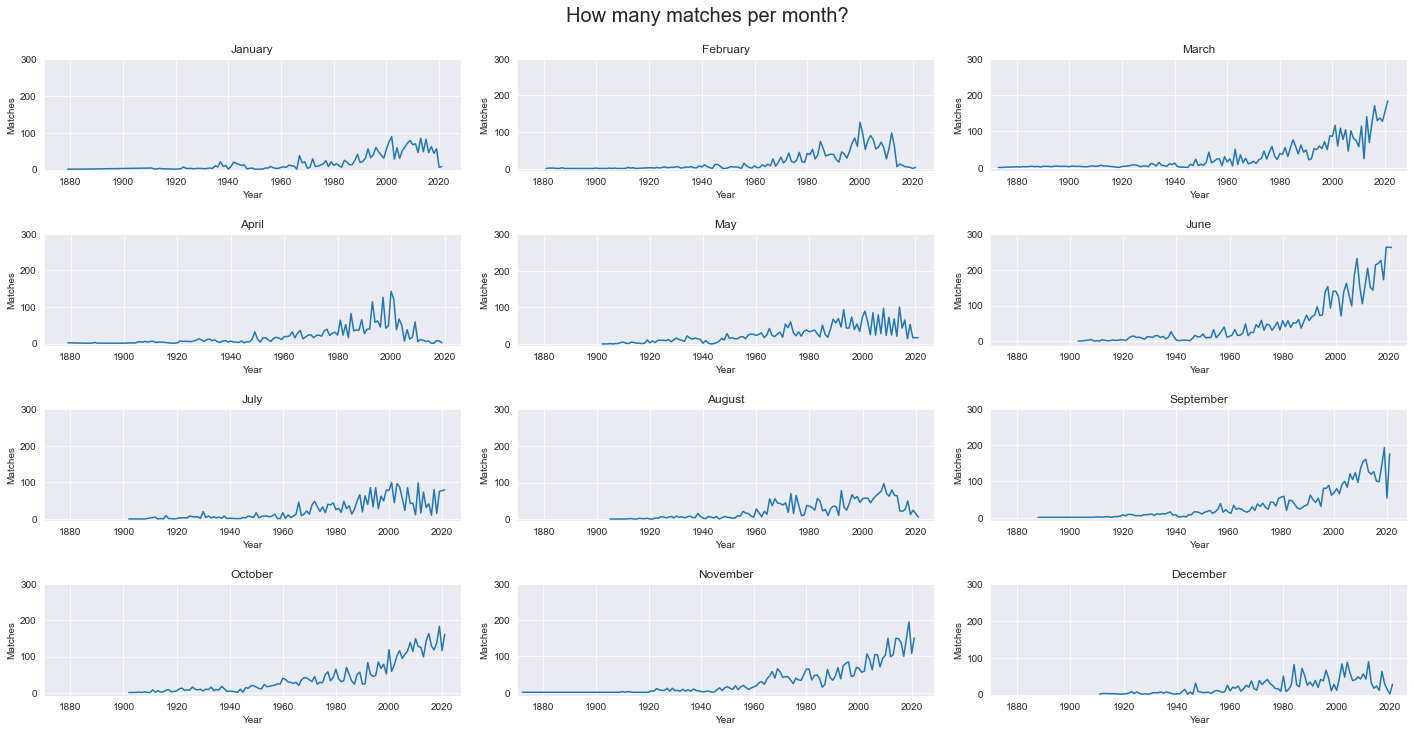

In [103]:
fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(20,10))
index = 0
ax = ax.flatten()

for value in games_per_month['Month Name'].unique():
    sns.lineplot(data=games_per_month[games_per_month['Month Name'] == value], x='Year', y='Count', ax=ax[index])
    ax[index].set_title(value, size=12)
    ax[index].set_ylabel(ylabel='Matches')
    ax[index].set_xlim(left=1870)
    ax[index].set_ylim(top=300)
    index+=1
    
fig.tight_layout(pad=2)
fig.suptitle('How many matches per month?', fontsize=20, y=1.025);

There has been a clear drop in the number of international matches in January, February, April and August, which makes sense since January, February and April are very active months for clubs and the pre-season is in August. 

March, September, October and November usually are months having matches of the qualifiers, which explains the increase. 

June and July are the months when the World Cup, Euro, Asian Cup and Copa America usually take place. But the next World Cup will be in November and December!

**How many matches per day of week?**

We've analyzed how international matches are spread over the various months of the year, now let's look at another dimension: days of the week.

In [98]:
games_per_dow = football_df[['Day of Week', 'Year']].value_counts().reset_index().sort_values(by=['Year'])
games_per_dow.rename(columns={0: 'Count'}, inplace=True)

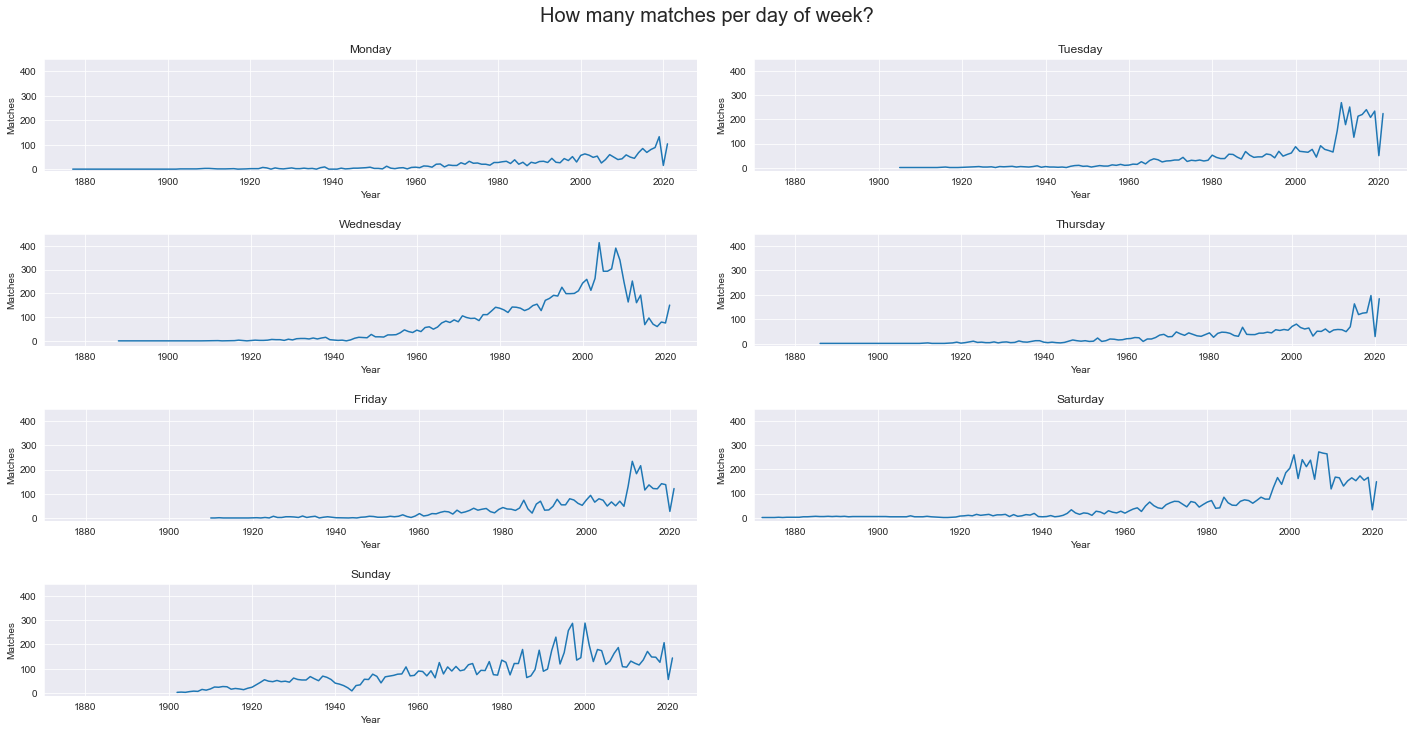

In [104]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(20,10))
index = 0
ax = ax.flatten()

for value in week_days:
    sns.lineplot(data=games_per_dow[games_per_dow['Day of Week'] == value], x='Year', y='Count', ax=ax[index])
    ax[index].set_title(value, size=12)
    ax[index].set_ylabel(ylabel='Matches')
    ax[index].set_xlim(left=1870)
    ax[index].set_ylim(top=450)
    index+=1

fig.delaxes(ax[7]) #The indexing is zero-based here
fig.tight_layout(pad=2)
fig.suptitle('How many matches per day of week?', fontsize=20, y=1.025);

The first games (between 1872 and 1900) took place mainly on Saturdays and Mondays. There was no match on Sundays until 1902, on Tuesdays until 1905, and on a Friday until 1910.

Even though every day of the week has shown an upward trend in the long term, Wednesdays were a common choice in the 2000s. Tuesdays, Thursdays, and Fridays have also become more popular in the last few years.

**Which cities hosted most games?**

In [ ]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="location script")

def func(x):
    city = x["City"]
    location = geolocator.geocode(city)
    if location is None:
        location = geolocator.geocode(city.title())
    if location is None:
        return None
    return [location.latitude, location.longitude]


football_cities_df = pd.DataFrame(football_df["City"].value_counts().sort_values(ascending=False).reset_index())
football_cities_df.rename(columns={'index': 'City', 'City': 'Count'}, inplace=True)
football_cities_df[["Latitude", "Longitude"]] = football_cities_df.apply(lambda x: func(x), axis=1, result_type='expand')

In [ ]:
# TODO -> Build dataframe with lat and long of all cities in the dataset.

In [ ]:
import folium

m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

for index, value in football_cities_df.iterrows():
    if not pd.isnull(value['Latitude']) and not pd.isnull(value['Longitude']):
        folium.Circle(
          location=[value['Latitude'], value['Longitude']],
          popup=value["City"],
          radius=float(value["Count"]) * 1000,
          color='crimson',
          fill=True,
          fill_color='crimson'
       ).add_to(m)
m

A large part of the larger bubbles can be seen in capitals, which was to be expected.

**Which city is better for home team?**

In [ ]:
home_team_wins_by_city = pd.DataFrame(
    football_df[(football_df["Neutral"] == False) & (football_df["Home Team"] == football_df["Winning Team"])][["Home Team", "City"]].value_counts().reset_index())

In [ ]:
t = pd.DataFrame(
    football_df[(football_df["Neutral"] == False) & (football_df["Home Team"] == football_df["Winning Team"])][["Home Team", "City"]].value_counts().reset_index()
).sort_values(by=0, ascending=False)

home_team_total_wins = pd.DataFrame(football_df[(football_df["Neutral"] == False) & (football_df["Home Team"] == football_df["Winning Team"])]["Home Team"].value_counts().reset_index()).rename(columns={'index': 'Home Team', 'Home Team': 'Count'})
t = t.merge(home_team_total_wins, how="inner", on=["Home Team"])
t["Win Ratio"] = t[0] / t["Count"]
t.sort_values(by=["Win Ratio"], inplace=True, ascending=False)

# TODO - get win ratio instead of total
t.drop_duplicates(subset=['Home Team'], keep='first', inplace=True)

t[["Latitude", "Longitude"]] = t.apply(lambda x: func(x), axis=1, result_type='expand')
t = t[t["Count"] > 25]

In [ ]:
m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

for index, value in t.iterrows():
    if not pd.isnull(value['Latitude']) and not pd.isnull(value['Longitude']):
        folium.Circle(
          location=[value['Latitude'], value['Longitude']],
          popup=f"{value['Home Team']} - {value['City']}:{value['Win Ratio']:.2f} ",
          radius=value["Win Ratio"] * 200000,
          color='crimson',
          fill=True,
          fill_color='crimson'
       ).add_to(m)
m

**Average number of goals per game per year**

In [ ]:
goals_per_year = pd.DataFrame(football_df.groupby(["Year"])["Total Goals"].sum().reset_index())

In [ ]:
games_per_year = pd.DataFrame(football_df["Year"].value_counts().sort_index().reset_index())
games_per_year.rename(columns={'index': 'Year', 'Year': 'Matches'}, inplace=True)

In [ ]:
goals_per_year = goals_per_year.merge(games_per_year, how="inner", on=["Year"])
goals_per_year["Goals Per Game"] = goals_per_year["Total Goals"] / goals_per_year['Matches']

In [ ]:
plt.figure(figsize=(20,10))
# ax = sns.lineplot(data=total_new_teams_per_decade_per_region, x="First Game Decade", y="Count", hue="Region")
ax = sns.lineplot(data=goals_per_year, x="Year", y="Goals Per Game")
ax.set_title('Average number of goals per game per year', size=20)
ax.set_xlabel(xlabel='Year', size=12)
ax.set_ylabel(ylabel='Goals Per Game', size=12)
ax.set(xticks=games_per_decade.index);

**Average number of goals per game per year per major tournament**

In [ ]:
goals_per_year = pd.DataFrame(football_df[football_df["Tournament"].isin(major_tournaments)].groupby(["Year", "Tournament"])["Total Goals"].sum().reset_index())

games_per_year = pd.DataFrame(football_df["Year"].value_counts().sort_index().reset_index())
games_per_year.rename(columns={'index': 'Year', 'Year': 'Matches'}, inplace=True)

In [ ]:
goals_per_year = goals_per_year.merge(games_per_year, how="inner", on=["Year"])
goals_per_year["Goals Per Game"] = goals_per_year["Total Goals"] / goals_per_year['Matches']

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(20,10))
index = 0
ax = ax.flatten()

for value in major_tournaments:
    sns.lineplot(data=goals_per_year[goals_per_year["Tournament"] == value], x="Year", y="Goals Per Game", ax=ax[index])
    index+=1

fig.delaxes(ax[11]) #The indexing is zero-based here
fig.suptitle("Average number of goals per game per year per major tournament", fontsize=20);

**Best Attacking Teams**

In [ ]:
# TODO divide home, neutral, away
# TODO goals per game instead of total goals
home_team_goals = pd.DataFrame(major_tournaments_df.groupby(by=["Home Team"])["Home Score"].sum().reset_index())
away_team_goals = pd.DataFrame(major_tournaments_df.groupby(by=["Away Team"])["Away Score"].sum().reset_index())
home_team_goals.rename(columns={'Home Team': 'Team'}, inplace=True)
away_team_goals.rename(columns={'Away Team': 'Team'}, inplace=True)
team_goals = home_team_goals.merge(away_team_goals, how="inner", on=["Team"])
team_goals["Total Goals"] = team_goals["Home Score"] + team_goals["Away Score"]
team_goals = team_goals.merge(game_counts.reset_index().rename(columns={'index': 'Team'}), how="inner", on=["Team"])
team_goals["Goals Per Game"] = team_goals["Total Goals"] / team_goals["Total"]
team_goals = team_goals[team_goals["Total"] > 31]
team_goals_top10 = team_goals.sort_values(by="Goals Per Game", ascending=False).head(10)

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.barplot(y=team_goals_top10["Team"], x=team_goals_top10["Goals Per Game"], orient='h')
ax.set_title("Best Attacking Teams", size=20)
ax.set_xlabel(xlabel="Goals Per Game", size=12)
ax.set_ylabel(ylabel="Team", size=12)

# Annotate value labels to each team
i = 0
for index, value in team_goals_top10.iterrows(): 
    plt.annotate(value["Goals Per Game"], xy=(value["Goals Per Game"]-0.2, i), color='white')
    i += 1

In [ ]:
# TODO divide home, neutral, away
# TODO goals per game instead of total goals
home_team_goals = pd.DataFrame(major_tournaments_df.groupby(by=["Home Team"])["Away Score"].sum().reset_index())
away_team_goals = pd.DataFrame(major_tournaments_df.groupby(by=["Away Team"])["Home Score"].sum().reset_index())
home_team_goals.rename(columns={'Home Team': 'Team'}, inplace=True)
away_team_goals.rename(columns={'Away Team': 'Team'}, inplace=True)
team_goals = home_team_goals.merge(away_team_goals, how="inner", on=["Team"])
team_goals["Total Goals"] = team_goals["Home Score"] + team_goals["Away Score"]
team_goals = team_goals.merge(game_counts.reset_index().rename(columns={'index': 'Team'}), how="inner", on=["Team"])
team_goals["Goals Per Game"] = team_goals["Total Goals"] / team_goals["Total"]
team_goals = team_goals[team_goals["Total"] > 31]
team_goals_top10 = team_goals.sort_values(by="Goals Per Game", ascending=True).head(10)

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.barplot(y=team_goals_top10["Team"], x=team_goals_top10["Goals Per Game"], orient='h')
ax.set_title("Best Defending Teams", size=20)
ax.set_xlabel(xlabel="Goals Per Game", size=12)
ax.set_ylabel(ylabel="Team", size=12)

# Annotate value labels to each team
i = 0
for index, value in team_goals_top10.iterrows(): 
    plt.annotate(value["Goals Per Game"], xy=(value["Goals Per Game"]-0.2, i), color='white')
    i += 1

**Which tournaments had the most games?**

To answer this, we are excluding friendly matches, qualifiers and tournaments with less than 100 matches.

In [ ]:
tournament_counts = pd.DataFrame(football_df["Tournament"].value_counts().reset_index()) \
    .rename(columns={'index': 'Tournament', 'Tournament': 'Count'})

tournament_counts = tournament_counts[(tournament_counts["Tournament"] != "Friendly") & 
                                      (~ tournament_counts["Tournament"].str.endswith('qualification')) & 
                                      (tournament_counts["Count"] >= 100)]
tournament_counts.reset_index(inplace=True)

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.barplot(y=tournament_counts["Tournament"], x=tournament_counts["Count"], orient='h')
ax.set_title("Which tournaments had the most games?", size=20)
ax.set_xlabel(xlabel="Matches", size=12)
ax.set_ylabel(ylabel="Tournament", size=12)

# Annotate value labels to each team
for index, value in tournament_counts.iterrows(): 
    plt.annotate(value['Count'], xy=(value['Count'] - 20, index + 0.2), color='white')

We will consider two competitions played between teams from all continents (World Cup and Confederations Cup) and the main competitions of each continent. So, these are the tournaments in the dataset that we will take as the main ones:
- FIFA World Cup
- Confederations Cup
- Copa América
- African Cup of Nations
- African Nations Championship	
- AFC Asian Cup
- Gold Cup
- CONCACAF Nations League
- UEFA Euro
- UEFA Nations League
- Oceania Nations Cup

Now we are ready to look at the top 10 of the teams that have played the most games in major tournaments.

**Which national teams have played the most games in major tournaments?**

In [ ]:
major_tournaments = ['FIFA World Cup', 'Confederations Cup', 'Copa América', 'African Cup of Nations', 
                     'African Nations Championship', 'AFC Asian Cup', 'Gold Cup', 'CONCACAF Nations League', 
                     'UEFA Euro', 'UEFA Nations League', 'Oceania Nations Cup']

major_tournaments_df = football_df[football_df["Tournament"].isin(major_tournaments)]

In [ ]:
home_team_game_counts = major_tournaments_df[major_tournaments_df["Neutral"] == False]["Home Team"].value_counts()

neutral_team_game_counts = pd.concat([major_tournaments_df[major_tournaments_df["Neutral"] == True]["Home Team"].value_counts(),
           major_tournaments_df[major_tournaments_df["Neutral"] == True]["Away Team"].value_counts()], axis=1)
neutral_team_game_counts["Neutral"] = neutral_team_game_counts["Home Team"] + neutral_team_game_counts["Away Team"]

away_team_game_counts = major_tournaments_df[major_tournaments_df["Neutral"] == False]["Away Team"].value_counts()

game_counts = pd.concat([home_team_game_counts, neutral_team_game_counts["Neutral"], away_team_game_counts], axis=1)
game_counts["Total"] = game_counts["Home Team"] + game_counts["Neutral"] + game_counts["Away Team"]
game_counts_top10 = game_counts.sort_values(by="Total", ascending=False).head(10)

In [ ]:
ax = game_counts_top10[["Home Team", "Neutral", "Away Team"]].plot(kind="bar", stacked=True, figsize=(20,10))
ax.set_title("Which national teams have played the most games in major tournaments?", size=20)
ax.set_xlabel(xlabel="National Team", size=12)
ax.set_ylabel(ylabel="Matches", size=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20);
ax.legend(["Home", "Neutral", "Away"], loc="upper right", title="Condition", fontsize=12);

# Annotate value labels to each team
i = 0
for index, value in game_counts_top10.iterrows(): 
    plt.annotate(int(value['Total']), xy=(i - 0.07, value['Total'] - 10), color='white')
    i += 1

It makes sense that teams from **South America (Brazil, Argentina, Uruguay, Chile, Paraguay, Peru and Colombia)** dominate this top 10. Copa América is the second most played tournament among the considered as major. Plus, the top 3 (Brazil, Argentina and Uruguay) add up to nine World Cups,  thirty nine Copa Américas, and five Confederations Cups!

Brazil, Colombia and Peru were invited to the Gold Cup. In three editions, Brazil was runner-up twice and third once. Colombia also played three times, reaching the final once and Peru reached the semifinals the only time they played in this competition.

**Mexico** is the most powerful team in the CONCACAF region. Mexico has won eleven Gold Cups and one Confederations Cup.

**Germany** is the only European team that appears, which is explained by the fact that it is the most successful European team. It has won four World Cups, three Euros and one Confederations Cup. 

**United States** has won seven Gold Cups and one CONCACAF Nations League (there has been only one edition). The high number of home games for the United States is due to having been the hosts or co-hosts of all editions of the Gold Cup. 

Mexico and the United States have participated in 10 and 4 editions of the Copa América. Mexico achieved two second places and three third places, while the United States finished fourth twice. This also contributed to the high number of games played by these two nations.

**Which teams have the best win ratio in major tournaments?**

In [ ]:
win_ratios = pd.concat([major_tournaments_df["Winning Team"].value_counts(), game_counts["Total"]], axis=1)
win_ratios["Ratio"] = win_ratios["Winning Team"] / win_ratios["Total"]

Before plotting, let's look at the statistics of the win_rations to define a threshold at the number of total games. It isn't fair to consider a team with few games the best win ratio, is it?

In [ ]:
win_ratios.describe()

25% of the teams have less than 21 games, I think that is a good threshold. 

In [ ]:
win_ratios = win_ratios[win_ratios["Total"] > 21]
win_ratios_top_10  = win_ratios.sort_values(by="Ratio", ascending=False).head(10)

plt.figure(figsize=(20,10))
ax = sns.barplot(x=win_ratios_top_10["Ratio"], y=win_ratios_top_10.index, orient='h')
ax.set_title("Which teams have the best win ratio in major tournaments?", size=20)
ax.set_xlabel(xlabel="Win Ratio", size=12)
ax.set_ylabel(ylabel="National Team", size=12)
ax.set_xlim(right=1)

# Annotate value labels to each team
i = 0
for index, value in win_ratios_top_10.iterrows(): 
    plt.annotate(float("{:.3f}".format(value['Ratio'])), xy=(value['Ratio']-0.03, i+0.075), color='white')
    i += 1

One of the fiercest rivalries in the history of football stands on top: Brazil and Argentina. 

Note that 5 of the 10 teams are European: Germany, France, Portugal, Netherlands and Italy.

United States, Iran and Nigeria aren't the teams with most titles in their regions but they usually go far, which explains the high win ratio.

**Which are the best teams per decade in major tournaments?**

Let's find out the golden eras of the best national teams. 

In [ ]:
win_ratio_per_decade = pd.concat(
    [pd.DataFrame(major_tournaments_df.groupby('Decade')['Winning Team'].apply(lambda x: x.value_counts())),
     pd.DataFrame(major_tournaments_df.groupby('Decade')['Home Team'].apply(lambda x: x.value_counts())),
     pd.DataFrame(major_tournaments_df.groupby('Decade')['Away Team'].apply(lambda x: x.value_counts()))],
    axis=1)

win_ratio_per_decade["Total"] = win_ratio_per_decade['Home Team'] + win_ratio_per_decade['Away Team']
win_ratio_per_decade["Ratio"] = win_ratio_per_decade['Winning Team'] / win_ratio_per_decade["Total"]

win_ratio_per_decade = win_ratio_per_decade[win_ratio_per_decade["Total"] > 5]
win_ratio_per_decade_top_3 = win_ratio_per_decade.sort_values(by=["Decade", "Ratio"], axis=0, na_position="first").groupby(level=0).tail(3)
win_ratio_per_decade_top_3 = win_ratio_per_decade_top_3.reset_index()

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = 'Decade', y = 'Ratio', hue ='level_1', data=win_ratio_per_decade_top_3, palette="tab20")
ax.set_title("Which are the best teams per decade in major tournaments?", size=20)
ax.set_xlabel(xlabel="Decade", size=12)
ax.set_ylabel(ylabel="Win Ratio", size=12)

# Annotate the top 3 national teams
for index, row in win_ratio_per_decade_top_3.iterrows():
    if row["Decade"] == 2010 and row["level_1"] == "North Macedonia":
        plt.annotate(row['level_1'], xy=(row['Decade'] - 9, row['Ratio']), fontsize=10)
    else:
        plt.annotate(row['level_1'], xy=(row['Decade'], row['Ratio']), fontsize=10)

In [ ]:
# TODO: Home team games --> as is or (Home Team == Country or Away Team == Country)?